<a href="https://colab.research.google.com/github/SavkinEgor/MADE_ML_Speech/blob/main/SPEECH_asr_lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [1]:
!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
679MB [00:10, 65.5MB/s]
/content/lab3


In [2]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

In [ ]:
# объединение кадров признаков с соответствующими им фонемам:
# side_context - контест справа и слева
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = [] # соответсиве фонема - MFCC
    priors_list = [0] * len(phones_dict) # веорятность как часто какая фонема считается
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        for frame in range(min(len(file_feats), len(file_ali))):
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = None
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [4]:
# Добавленный код

# объединение кадров признаков с соответствующими им фонемам:
# side_context - контест справа и слева
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = [] # соответсиве фонема -MFCC
    priors_list = [0] * len(phones_dict) # веорятность как часто какая фонема считается
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        for frame in range(1, min(len(file_feats), len(file_ali)) - 1):
          # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
            if side_context:
                data_list.append(np.concatenate((
                      file_feats[frame - 1],
                      file_feats[frame],
                      file_feats[frame + 1],
                      [phones_dict[file_ali[frame]]],
                      )))
            else:
                data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
          # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = True # CONTEXT FLAG
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [5]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(self.device), batch_ys.to(self.device)

In [ ]:
class MyNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 256
        n_nodes_hl2 = 256
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return (x)

In [6]:
class MyNetUpgraded(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNetUpgraded, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 512
        n_nodes_hl2 = 512
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)
        # BN layers:
        self.bn1 = nn.BatchNorm1d(n_nodes_hl1)
        self.bn2 = nn.BatchNorm1d(n_nodes_hl2)
        self.bn3 = nn.BatchNorm1d(n_nodes_hl3)
        self.bn4 = nn.BatchNorm1d(n_nodes_hl4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = torch.relu(self.fc4(x))
        x = self.bn4(x)
        x = torch.squeeze(x)
        x = self.fc5(x)
        return (x)

In [31]:
class MyNetUpgraded(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNetUpgraded, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 512
        n_nodes_hl2 = 512
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)
        # DO layers:
        self.do1 = nn.Dropout(0.2)
        self.do2 = nn.Dropout(0.2)
        self.do3 = nn.Dropout(0.2)
        self.do4 = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.do1(x)
        x = torch.relu(self.fc2(x))
        x = self.do2(x)
        x = torch.relu(self.fc3(x))
        x = self.do3(x)
        x = torch.relu(self.fc4(x))
        x = self.do4(x)
        x = self.fc5(x)
        return (x)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyNetUpgraded(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 2.2558



loss is: 1.8948



loss is: 1.8031



loss is: 1.7507



loss is: 1.7158



loss is: 1.6889



loss is: 1.6682



loss is: 1.6496



loss is: 1.6357



loss is: 1.6221
Time is: 1 min 54 sec


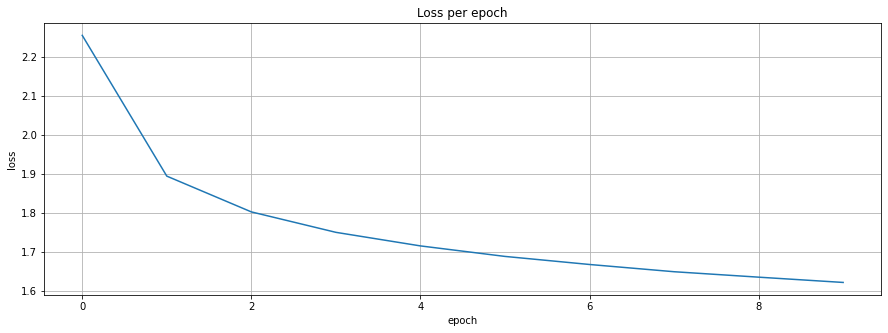

In [33]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [34]:
net.cpu()
net.eval()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        # output = net.forward(ftr.reshape(1,ftr.shape[0]))
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.551


In [35]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]
net.cpu()
with torch.no_grad():
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        # output = net.forward(ftr.reshape(1,ftr.shape[0]))
        output = net.forward(ftr)
        predict_label = output.argmax().item()
        
        class_correct[predict_label] += (predict_label == int(true_label))
        class_total[int(true_label)] += 1

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))


SIL: 0.97 : 21313/22077
SPN: 0.00 : 0/574
AA0: 0.00 : 0/41
AA1: 0.44 : 778/1785
AA2: 0.00 : 0/72
AE0: 0.00 : 0/35
AE1: 0.52 : 1923/3729
AE2: 0.00 : 0/109
AH0: 0.39 : 2232/5689
AH1: 0.26 : 505/1953
AH2: 0.00 : 0/41
AO0: 0.00 : 0/29
AO1: 0.47 : 902/1938
AO2: 0.00 : 0/67
AW0: 0.00 : 0/8
AW1: 0.35 : 392/1123
AW2: 0.00 : 0/38
AY0: 0.00 : 0/34
AY1: 0.61 : 1794/2949
AY2: 0.00 : 0/222
B  : 0.38 : 583/1516
CH : 0.24 : 199/842
D  : 0.33 : 1336/4049
DH : 0.34 : 701/2039
EH0: 0.00 : 0/51
EH1: 0.31 : 890/2826
EH2: 0.00 : 0/100
ER0: 0.38 : 984/2573
ER1: 0.23 : 214/949
ER2: 0.00 : 0/12
EY0: 0.00 : 0/31
EY1: 0.59 : 1331/2272
EY2: 0.00 : 0/116
F  : 0.61 : 1438/2359
G  : 0.19 : 144/754
HH : 0.43 : 936/2189
IH0: 0.08 : 221/2646
IH1: 0.25 : 586/2370
IH2: 0.00 : 0/99
IY0: 0.36 : 787/2184
IY1: 0.63 : 1483/2366
IY2: 0.00 : 0/63
JH : 0.23 : 143/617
K  : 0.55 : 1716/3126
L  : 0.67 : 2804/4175
M  : 0.50 : 1610/3226
N  : 0.65 : 3953/6051
NG : 0.31 : 388/1261
OW0: 0.00 : 0/210
OW1: 0.39 : 798/2053
OW2: 0.00 : 0/

### Распознавание по словарю с помощью нейронки

In [20]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [37]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [21]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(len(features)):
        ftr_frame = features[frame]
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    # Добавить констекст тоже
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [22]:
def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(1, len(features) - 1):
      # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
        ftr_frame = np.concatenate((features[frame - 1], features[frame], features[frame + 1]))
      # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    # Добавить констекст тоже
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [23]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [ ]:
# Без контекста
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: no_ad89eb1e_nohash_0        ==> NO
result: no_4394fc7c_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 2.06 sec
------------------------------------------------------------


In [ ]:
# С контекстом
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: no_ad89eb1e_nohash_0        ==> NO
result: no_4394fc7c_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
------------------------------------------------------------
WER is: 10.00%
Total time is: 1.97 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [ ]:
# Без контекста
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)


result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> THREE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: eight_da584bc0_nohash_4     ==> SIX
result: nine_ccea893d_nohash_0      ==> NINE
result: two_fb2f3242_nohash_0       ==> TWO
result: four_fce65496_nohash_0      ==> FOUR
result: two_fce65496_nohash_0       ==> TWO
result: seven_fd32732a_nohash_0     ==> SEVEN
result: one_fc2411fe_nohash_0       ==> NINE
result: one_ffa76c4a_nohash_0       ==> FOUR
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: five_f852895b_nohash_0      ==> FIVE
result: three_fce96bac_nohash_0     ==> THREE
result: eight_daf230ac_nohash_0     ==> SIX
result: three_feb1d305_nohash_0     ==> THREE
result: six_ffbb695d_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
------------------------------------------------------------
WER is: 30.00%
Total time is: 16.76 sec

In [ ]:
# С контекстом
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)


result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: eight_da584bc0_nohash_4     ==> EIGHT
result: nine_ccea893d_nohash_0      ==> NINE
result: two_fb2f3242_nohash_0       ==> TWO
result: four_fce65496_nohash_0      ==> FOUR
result: two_fce65496_nohash_0       ==> TWO
result: seven_fd32732a_nohash_0     ==> SEVEN
result: one_fc2411fe_nohash_0       ==> NINE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: five_f852895b_nohash_0      ==> FIVE
result: three_fce96bac_nohash_0     ==> THREE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: three_feb1d305_nohash_0     ==> THREE
result: six_ffbb695d_nohash_0       ==> SIX
result: six_ffd2ba2f_nohash_0       ==> SIX
------------------------------------------------------------
WER is: 5.00%
Total time is: 15.71 se

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

Качестов выросло очень приличо, особенно заметно это на датасете с цифрами. На датасете с YES-NO качество упало.

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

In [39]:
# Доюавим контекст в 2 справа и слева

# объединение кадров признаков с соответствующими им фонемам:
# side_context - контест справа и слева
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = [] # соответсиве фонема -MFCC
    priors_list = [0] * len(phones_dict) # веорятность как часто какая фонема считается
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        for frame in range(2, min(len(file_feats), len(file_ali)) - 2):
          # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
            if side_context:
                data_list.append(np.concatenate((
                      file_feats[frame - 2],
                      file_feats[frame - 1],
                      file_feats[frame],
                      file_feats[frame + 1],
                      file_feats[frame + 2],
                      [phones_dict[file_ali[frame]]],
                      )))
            else:
                data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
          # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
    return data_list, np.array(priors_list)/sum(priors_list)

def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(2, len(features) - 2):
      # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
        ftr_frame = np.concatenate((features[frame - 2], features[frame - 1],
                                    features[frame],
                                    features[frame + 1], features[frame + 2]))
      # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    # Добавить констекст тоже
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

side_context = True # CONTEXT FLAG
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [26]:
# С батчнормом
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        nnet.eval()
        with torch.no_grad():
            # не очень, конечно, имеет смысл, так как инференс мы делаем не по батчам
            ftr = torch.from_numpy(input_feats).float()
            predicts = nnet.forward(ftr.reshape(1,ftr.shape[0]))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальным в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [ ]:
# Эксепримент 1
net.eval()
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: yes_ff63ab0b_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 0.00%
Total time is: 2.60 sec
------------------------------------------------------------


In [ ]:
# Эксепримент 1
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)


result: five_f852895b_nohash_0      ==> FIVE
result: two_fce65496_nohash_0       ==> TWO
result: four_fce65496_nohash_0      ==> FOUR
result: one_ffa76c4a_nohash_0       ==> FOUR
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: zero_f852895b_nohash_0      ==> ZERO
result: seven_fd32732a_nohash_0     ==> SEVEN
result: six_ffd2ba2f_nohash_0       ==> SIX
result: eight_daf230ac_nohash_0     ==> EIGHT
result: six_ffbb695d_nohash_0       ==> SIX
result: two_fb2f3242_nohash_0       ==> TWO
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> NINE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_fc2411fe_nohash_0       ==> ONE
result: four_ffbb695d_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> EIGHT
result: three_feb1d305_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 5.00%
Total time is: 21.40 se

In [27]:
# Эксепримент 2(YES-NO Батчнорм)
net.eval()
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: no_ad89eb1e_nohash_0        ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 3.84 sec
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [28]:
# Эксепримент 2(DIGITS Батчнорм)
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)


result: one_fc2411fe_nohash_0       ==> ONE
result: nine_ccea893d_nohash_0      ==> NINE
result: one_ffa76c4a_nohash_0       ==> FOUR
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffbb695d_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


result: eight_da584bc0_nohash_4     ==> ONE
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: four_fce65496_nohash_0      ==> FOUR
result: eight_daf230ac_nohash_0     ==> ZERO
result: five_f852895b_nohash_0      ==> FIVE
result: nine_fbe51750_nohash_0      ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: three_fce96bac_nohash_0     ==> THREE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: two_fce65496_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: three_feb1d305_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 15.00%
Total time is: 29.94 sec
------------------------------------------------------------


In [40]:
# Эксепримент 3(YES-NO контекст в 2)
net.eval()
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: no_ad89eb1e_nohash_0        ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 2.65 sec
------------------------------------------------------------


In [41]:
# Эксепримент 3(DIGITS контекст в 2)
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)


result: one_fc2411fe_nohash_0       ==> ONE
result: nine_ccea893d_nohash_0      ==> NINE
result: one_ffa76c4a_nohash_0       ==> ONE
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffbb695d_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: eight_da584bc0_nohash_4     ==> EIGHT
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: four_fce65496_nohash_0      ==> FOUR
result: eight_daf230ac_nohash_0     ==> EIGHT
result: five_f852895b_nohash_0      ==> FIVE
result: nine_fbe51750_nohash_0      ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: three_fce96bac_nohash_0     ==> THREE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: two_fce65496_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: three_feb1d305_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 0.00%
Total time is: 21.26 sec

In [ ]:
# слои поменять
# ignore index в лоссе
# добавить шедулер

Чуть экспериментов

Оригинальная сеть:  
frame accuarcy: 0.424  
WER YES-NO: 0%  
WER DIGITS: 30%  
Сеть с контекстом в 1 и с нормализацией:  
frame accuarcy: 0.527  
WER YES-NO: 0% 
WER DIGITS: 15%
Сеть с контекстом в 1 и с дропаутом:  
frame accuarcy: 0.507  
WER YES-NO: 0%  
WER DIGITS: 5% 
Сеть с контекстом в 2 и с дропаутом:  
frame accuarcy: 0.551  
WER YES-NO: 0%  
WER DIGITS: 0%  


In [46]:
data_set.num_batches(batch_size)

4481

In [47]:
# Добились неплохих результатов, а теперь добавим Шедулер и чуть уменьшим кол-во эпох обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256
epoches = 9
lr_param = 0.0003
# training network model:
start = time.time() 
net = MyNetUpgraded(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr_param)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr_param, 
                                            steps_per_epoch=data_set.num_batches(batch_size),
                                            epochs=epoches,
                                            anneal_strategy='linear')

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(epoches):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 2.6767



loss is: 1.9475



loss is: 1.8045



loss is: 1.7303



loss is: 1.6809



loss is: 1.6461



loss is: 1.6174



loss is: 1.5949



loss is: 1.5775
Time is: 1 min 45 sec


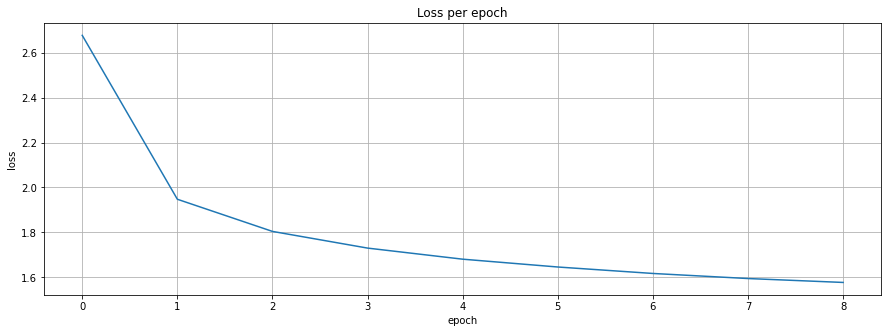

In [48]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [49]:
net.cpu()
net.eval()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        # output = net.forward(ftr.reshape(1,ftr.shape[0]))
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.560


In [50]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]
net.cpu()
with torch.no_grad():
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        # output = net.forward(ftr.reshape(1,ftr.shape[0]))
        output = net.forward(ftr)
        predict_label = output.argmax().item()
        
        class_correct[predict_label] += (predict_label == int(true_label))
        class_total[int(true_label)] += 1

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))


SIL: 0.97 : 21527/22291
SPN: 0.00 : 0/613
AA0: 0.00 : 0/35
AA1: 0.40 : 711/1756
AA2: 0.00 : 0/76
AE0: 0.00 : 0/42
AE1: 0.56 : 2082/3692
AE2: 0.00 : 0/102
AH0: 0.41 : 2304/5645
AH1: 0.24 : 453/1899
AH2: 0.00 : 0/48
AO0: 0.00 : 0/28
AO1: 0.49 : 936/1925
AO2: 0.00 : 0/44
AW0: 0.00 : 0/9
AW1: 0.35 : 392/1122
AW2: 0.00 : 0/35
AY0: 0.00 : 0/49
AY1: 0.62 : 1837/2979
AY2: 0.00 : 0/205
B  : 0.36 : 549/1540
CH : 0.24 : 213/876
D  : 0.31 : 1246/3976
DH : 0.36 : 741/2040
EH0: 0.00 : 0/48
EH1: 0.33 : 993/3020
EH2: 0.00 : 0/91
ER0: 0.45 : 1164/2611
ER1: 0.22 : 206/939
ER2: 0.00 : 0/13
EY0: 0.00 : 0/39
EY1: 0.57 : 1361/2369
EY2: 0.00 : 0/114
F  : 0.62 : 1483/2394
G  : 0.16 : 121/747
HH : 0.45 : 992/2206
IH0: 0.12 : 308/2670
IH1: 0.26 : 593/2262
IH2: 0.00 : 0/94
IY0: 0.36 : 770/2149
IY1: 0.64 : 1548/2412
IY2: 0.00 : 0/41
JH : 0.24 : 139/579
K  : 0.58 : 1851/3188
L  : 0.66 : 2778/4206
M  : 0.50 : 1640/3290
N  : 0.68 : 4066/5965
NG : 0.33 : 434/1313
OW0: 0.00 : 0/212
OW1: 0.38 : 763/2027
OW2: 0.00 : 0/

In [51]:
# Эксепримент 3(YES-NO контекст в 2, использование шедулера и уменьшение эпох)
net.eval()
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: no_ad89eb1e_nohash_0        ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
------------------------------------------------------------
WER is: 10.00%
Total time is: 2.63 sec
------------------------------------------------------------


In [52]:
# Эксепримент 3(DIGITS контекст в 2, использование шедулера и уменьшение эпох)
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)


result: one_fc2411fe_nohash_0       ==> ONE
result: nine_ccea893d_nohash_0      ==> NINE
result: one_ffa76c4a_nohash_0       ==> ONE
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffbb695d_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: eight_da584bc0_nohash_4     ==> EIGHT
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: four_fce65496_nohash_0      ==> FOUR
result: eight_daf230ac_nohash_0     ==> EIGHT
result: five_f852895b_nohash_0      ==> FIVE
result: nine_fbe51750_nohash_0      ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: three_fce96bac_nohash_0     ==> THREE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: two_fce65496_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: three_feb1d305_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 0.00%
Total time is: 20.64 sec

Сеть с контекстом в 2 и с дропаутом и с шедулером в обучении:  
frame accuarcy: 0.560  
WER YES-NO: 10%  
WER DIGITS: 0% 

Применение Шедулера позволило немного сократить время обучения и увеличть точность распозонвания фонем, но на датасете с YES-NO ошибка увеличилась, но, возможно, это просто из-за некоторой стахостичности, маленького контекста и не проведенной настройки beam_pruning.